In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack

In [2]:
@kwdef struct IZParameter{FT}
    C::FT = 100  # 膜容量 (pF)
    a::FT = 0.03 # 回復時定数の逆数 (1/ms)
    b::FT = -2 # u の v に対する共鳴度合い (pA/mV)
    d::FT = 100 # 発火で活性化される正味の外向き電流 (pA)
    k::FT = 0.7 # ゲイン (pA/mV)
    vthr::FT = -40 # 閾値電位 (mV)
    vrest::FT = -60 # 静止膜電位 (mV)
    vreset::FT = -50 # リセット電位 (mV)
    vpeak::FT = 35 #　ピーク電位 (mV)
end

@kwdef mutable struct IZ{FT}
    param::IZParameter = IZParameter{FT}()
    N::UInt32
    v::Vector{FT} = fill(param.vrest, N)
    u::Vector{FT} = zeros(N)
    fire::Vector{Bool} = zeros(Bool, N)
end

In [3]:
function update!(variable::IZ, param::IZParameter, I::Vector, dt)
    @unpack N, v, u, fire = variable
    @unpack C, a, b, d, k, vthr, vrest, vreset, vpeak = param
    @inbounds for i = 1:N
        v[i] += dt/C * (k*(v[i]-vrest)*(v[i]-vthr) - u[i] + I[i])
        u[i] += dt * (a * (b * (v[i]-vrest) - u[i]))
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vpeak
        v[i] = ifelse(fire[i], vreset, v[i])
        u[i] += ifelse(fire[i], d, 0)
    end
end

update! (generic function with 1 method)

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(150f0 * ((t .> 50) - (t .> 200)) + 300f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)
uarr = zeros(Float32, nt, N)

# modelの定義
neurons = IZ{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, I[i, :], dt)
    varr[i, :] = neurons.v
    uarr[i, :] = neurons.u
end

  0.114824 seconds (740.36 k allocations: 22.641 MiB, 6.48% gc time, 55.42% compilation time)


In [5]:
using Plots

In [6]:
p1 = plot(t, varr[:, 1])
p2 = plot(t, uarr[:, 1])
p3 = plot(t, I[:, 1])
plot(p1, p2, p3, 
    title= ["Regular Spiking (RS) Neurons" "" ""],
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "Recovery\n current (pA)" "Injection\n current (pA)"],
    layout = grid(3, 1, heights=[0.5, 0.25, 0.25]), legend = false, size=(500, 400))

In [7]:
# 記録用
varr_ib = zeros(Float32, nt, N)
varr_ch = zeros(Float32, nt, N)

I = repeat(500f0 * ((t .> 50) - (t .> 200)) + 700f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# IB neurons
neurons_ib = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 150, a = 0.01, b = 5, k =1.2, d = 130, vrest = -75, vreset = -56, vthr = -45, vpeak = 50))

# CH neurons
neurons_ch = IZ{Float32}(N=N, 
    param=IZParameter{Float32}(C = 50, a = 0.03, b = 1, k =1.5, d = 150, vrest = -60, vreset = -40, vthr = -40, vpeak = 35))

# simulation
@time for i = 1:nt
    update!(neurons_ib, neurons_ib.param, I[i, :], dt)
    update!(neurons_ch, neurons_ch.param, I[i, :], dt)
    varr_ib[i, :] = neurons_ib.v
    varr_ch[i, :] = neurons_ch.v
end

  0.068368 seconds (759.89 k allocations: 19.148 MiB, 12.00% gc time)


In [8]:
p1 = plot(t, varr_ib[:, 1])
p2 = plot(t, varr_ch[:, 1])
p3 = plot(t, I[:, 1])
p4 = plot(t, I[:, 1])
plot(p1, p2, p3, p4,
    title = ["IB Neurons" "CH neurons" "" ""],
    xlabel = ["" "" "Times (ms)" "Times (ms)"], 
    ylabel= ["Membrane\n potential (mV)" "" "Injection\n current (pA)" ""],
    layout = grid(2, 2, heights=[0.7, 0.3], widths=[0.5, 0.5]), legend = false, size=(600, 300))

In [9]:
# Excitatory neurons    Inhibitory neurons
Ne = 800;               Ni = 200
re = rand(Ne,1);        ri = rand(Ni,1)
a = [0.02*ones(Ne,1);   0.02 .+ 0.08*ri]
b = [0.2*ones(Ne,1);    0.25 .- 0.05*ri]
c = [-65 .+ 15*re.^2;   -65*ones(Ni,1)]
d = [8 .- 6*re.^2;      2*ones(Ni,1)]
S = [0.5*rand(Ne+Ni,Ne) -rand(Ne+Ni,Ni)] # synaptic weight
v = -65*ones(Ne+Ni,1)   # Initial values of v
u = b .* v              # Initial values of u
firings = []            # spike timings

for t=1:1000 # simulation of 1000 ms
    I=[5*randn(Ne,1); 2*randn(Ni,1)] # thalamic input
    fired = findall(v[:, 1] .>= 30) # indices of spikes
    firings = t==1 ? [t .+ 0*fired fired] : [firings; [t .+ 0*fired fired]]
    v[fired]=c[fired]
    u[fired]=u[fired]+d[fired]
    I = I + sum(S[:,fired], dims=2)
    v = v .+0.5*(0.04*v.^2+5*v .+140 -u+I) # step 0.5 ms for numerical stability
    v = v .+0.5*(0.04*v.^2+5*v .+140 -u+I) 
    u = u+a.*(b.*v-u)
end

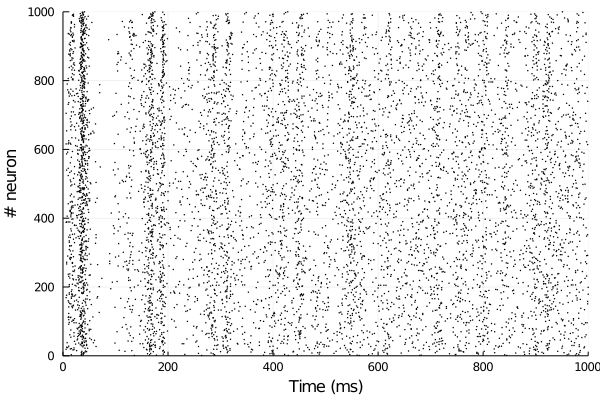

In [10]:
scatter(firings[:,1], firings[:,2], markersize=1, markercolor="black", 
    xlabel="Time (ms)", ylabel="# neuron", xlim=(0, 1000), ylim=(0, 1000), legend=false)